# Derviving and implmenting resnet2resnet transformations

TODO: Describe zero initializations

TODO: Define the two convolutions 

TODO: describe extending a kernel with C1 filters, and extending with 2\*C2 filters. Where we initialize to W and -W

TODO: Initialization of a new identity layer (net2deeper transform) is the same as a net2wider transform, with C1 = 0.

TODO: Describe why this doesn't work, because it only works with odd activation functions (i.e. tanh). This is obviously too restrictive.

TODO: describe initializing with W and W, and then adding the $beta$ and $-beta$ on a 1x1 conv

TODO: describe the additional benefit of the 1x1 convs to provide a consistent dimension on the output

TODO: Add our final diagrams to help explain

TODO: add references to 231n pytorch tutorials (Justin Johnson's github) + the source code for convs, https://pytorch.org/docs/master/_modules/torch/nn/modules/conv.html as it's very instructive of how we will manipulate them

## Preamble

Here's just some code to make matplotlib libraries etc play nice with jupyter notebooks. (So we just run the below code and don't worry about how it works).

This will setup plotting how we want it, make matplotlib and seaborn figures run inline.

In [159]:
# Some imports
import random
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import time

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Seaborn config
sns.set(color_codes=True)

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports :)

In [160]:
# import the pytorch and numpy libraries we need now
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np

## Running on GPU

Run the following code, uncomment appropriately if you want to run on a GPU.

This is super hacky, but who cares! By replacing the float type with the cuda float type in PyTorch, everything just runs on GPU by default :)

In [161]:
# device = t.device('cpu') # Uncomment this to run on CPU
device = t.device('cuda') # Uncomment this to run on GPU

## Initializing the kernel

Here we provide the code to zero initialize a module. We begin by defining the normal (Xavier and He) initializations for numpy arrays, and extend them to provide initializations for "widennings" of convolutional filters. The aim for this portion of the notebook is to take a set of convolutional filters F, and initialize further filters, W, and return a concatenated set of filters, [F;W;W]. (N.B. we use ';' for concatenation).

In [162]:
def _conv_xavier_initialize(filter_shape, overrid_input_channels=None, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "He initialization".
    The weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/(n_in + n_out)).
    
    This is the initialization of choice for layers with non ReLU activations.
    
    The filter shape should be [output_channels, input_channels, width, height]. So here, n_in = input_channels 
    and n_out = width * height * output_channels.
    
    When "widening" an filter, from C1 output filters, to C1 + 2*C2 filters, then we want to initialize the 
    additional 2*C2 layers, as if there are C1+2*C2 filters in the output, and therefore we provide the 
    option to override the number of output filters.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization for
    :param override_output_channels: Override for the number of input filters in the filter_shape (optional)
    :param override_output_channels: Override for the number of output filters in the filter_shape (optional)
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    out_channels, in_channels, width, height = filter_shape
    if override_input_channels is not None:
        in_channels = override_input_channels
    if override_output_channels is not None:
        out_channels = override_output_channels
    filter_shape = (width, height, in_channels, out_channels)    
    
    scale = np.sqrt(2.0 / (in_channels + width*height*out_chanels))
    return scale * np.random.randn(*filter_shape).astype(np.float32) 
    
    
    
    

def _conv_he_initialize(filter_shape, override_input_channels=None, override_output_channels=None):
    """
    Initialize a convolutional filter, with shape 'filter_shape', according to "Xavier initialization".
    Each weight for each hidden unit should be drawn from a normal distribution, with zero mean and stddev of 
    sqrt(2/n_in).
    
    This is the initialization of choice for layers with ReLU activations.
    
    The filter shape should be [output_channels, input_channels, width, height]. So here, n_in = input_channels.
    
    As the initization only depends on the number of inputs (the number of input channels), unlike Xavier 
    initialization, we don't need to be able to override the number of output_channels.
    
    :param filter_shape: THe shape of the filter that we want to produce an initialization 
    :param override_output_channels: Override for the number of input filters in the filter_shape (optional)
    :param override_output_channels: unused
    :return: A numpy array, of shape 'filter_shape', randomly initialized according to He initialization.
    """
    in_channels = filter_shape[1]
    if override_input_channels is not None:
        in_channels = override_input_channels
    scale = np.sqrt(2.0 / in_channels)
    return scale * np.random.randn(*filter_shape).astype(np.float32)


In [163]:
def _init_filter_with_repeated_output(extending_filter_shape, existing_filter=None, init_type='He'):
    """
    We want to initialize a filter with appropriately initialized weights.
    
    Let F be the 'existing_filter', with shape [C1,I,W,H]. Let extending_filter_shape be [2*C2,I,W,H]. 
    If the value for 2*C2 is odd or non-positive, then it's an error
    We then want to initialize E of shape [C2,I,W,H], according to the given initialization, 
    and then we want to return the concatenation [F;E;E].
    
    To make a fresh/new filter, with repeated weights, let 'existing_filter' be None, and it will 
    return just [E;rE], as F is "empty".
    
    :param extending_filter_shape: The shape of the new portion of the filter to return. I.e. [W,H,I,2*C2]
    :param existing_filter: If not None, it must have shape [W,H,I,C1], this is the existing filter.
    :param init_type: The type of initialization to use
    :return: A filter, extended by 2*C2 channels. I.e. the filter [F;E;E]
    """
    # Unpack params input
    twoC2, I, W, H = extending_filter_shape
    C2 = twoC2 // 2
    C1 = 0 if existing_filter is None else existing_filter.shape[0]
    
    # Error checking
    if twoC2 % 2 != 0:
        # TODO: log a descriptive error in final implementation
        raise Exception()
    elif existing_filter is not None and (W != existing_filter.shape[2] 
        or H != existing_filter.shape[3] or I != existing_filter.shape[1]):
        # TODO: log a descriptive error in final implementation
        raise Exception()
    
    # Canvas for the new numpy array that we want to return, and copy existing filter weights
    canvas = np.zeros((C1+twoC2, I, W, H)).astype(np.float32)
    if existing_filter is not None:
        canvas[:C1,:,:,:] = existing_filter

    # Initialize the new weights, and copy that into the canvas (twice)
    new_channels_weights = None
    if init_type == 'He':
        new_channels_weights = _conv_he_initialize((C2,I,W,H))
    elif init_type == 'Xavier':
        new_channels_weights = _conv_xavier_initialize((C2,I,W,H), C1+twoC2)
    else:
        # TODO: log a descriptive error in final implementation
        raise Exception()
    
    canvas[C1:C1+C2,:,:,:] = new_channels_weights
    canvas[C1+C2:C1+twoC2,:,:,:] = new_channels_weights

    # Done :)
    return canvas

In [164]:
# This was just a play of how to use Conv2d :)

# conv = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=4, stride=1, padding=0, dilation=1, groups=1, bias=True)
# print(conv.weight.size())
# print(conv.weight.data)
# conv.weight.data = t.ones((2,2,4,4))
# conv.bias.data = t.zeros((2))
# print(conv.weight.data)
# print(conv(t.ones(1,2,8,8)))
# print(conv.bias.data)
# conv.bias.data *= 0.0
# print(conv.bias.data)

# print(t.Tensor(np.ones((1,2))))


# And this is some play of how to actually make it all wok with backprop...

class tst(nn.Module):
    def __init__(self, a, b):
        super(tst, self).__init__()
        self.fc1 = nn.Linear(a, b)
    def forward(self, x):
        return self.fc1(x)
    
model = tst(256, 10)
model2 = tst(10, 3)
inp = t.ones((1,256))
out = model2(model(inp))
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(out, t.tensor([[0.0,0.0,1.0]]))
loss.backward()

model = tst(128,10)
inp = t.ones((1,128))
out = model2(model(inp))
loss = loss_fn(out, t.tensor([[0.0,0.0,1.0]]))
loss.backward()




# THIS DOESN'T WORK:

# model.fc1.weight.data = t.ones((4,128))
# model.fc1.bias.data = t.zeros((4,))

# print(model.fc1.weight.data.size())
# print(model.fc1.bias.data.size())

# inp = t.ones((1,128))
# out = model(inp)
# loss = loss_fn(out, t.tensor([[0.0,0.0,1.0,0.0]]))
# loss.backward(create_graph=True)
        

## Putting it together

Now that we can extend a filter, with weights F, to [F;W;W], we use it to build our zero module using the following code

In [165]:
# def _compute_filter_shape_v1(inputs, output_channels):
#     """
#     (Helper function for 'init_zero_module_v1').
#     Computes the shape of the filter to be used, give the number of 'output_channels' we wish to have
#     Also provides error checking!
    
#     As v1 is just prototyping, we're just going to always set a filter size of 4x4.
    
#     Also in v1, we completely ignore padding and stride, and let tf handle appropriate padding so that 
#     the output width and height is the same as the width and height input.
    
#     We check that the numbe of output channels is even, because we want the output to be symmetric in 
#     the output channels. We also check that the number of output channels is at least the number of 
#     input channels, because we want to add residual connections, and we can't really do that unless 
#     in_channels <= out_channels
#     """
#     # 0th item is batch size
#     in_channels, width, height = inputs.get_shape().as_list()[1:] 
    
#     if output_channels % 2 != 0:
#         # TODO: log a descriptive error in final implementation
#         raise Exception()
#     if in_channels > output_channels:
#         # TODO: log a descriptive error in final implementation
#         raise Exception()
    
#     return (output_channels, in_channels, 4,4)
    
        
        
class R2R_block_v1(nn.Module):
    """
    Defines a R2R module, version 1, this will be our first iteration and so we will make some (arbitrary) design choices for 
    now, just to make prototyping easier.
    
    An R2R module consists of the following network layers/operations:
        (optional) max pool
        k*k conv2d
        batchnorm
        activation function
        1*1 conv2d
        
    Outline of the computation that we perform:
        0. (Optionally) reduce the input dimensions, using a max pool
        1. Input shape of [D,A,A], and desired output shape is [2K,A,A]
        2. Make a filter, with shape [2K,D,4,4], where [:K,D,4,4] is identitcal to [K:,D,4,4], 
            that is: set the weights for [K+j,:,:,:] equal to  [j,:,:,:]
        3. Add noise, at an appropriate scale, to break symmetry
        4. Add batch norm, if we want to
        5. Apply our non-linearity, 
        6. By the symmetry introduced, the output after the non-linearity should be of the form [W'; W'] 
            (that is, still symmetric)
        7. Use a 1x1 convolution to use the symmetry to make the output from the previous layer cancel out 
            (note that this also allows use to provide dimensionality reduction, and, output a consistent number 
            of filters, helping to keep everything modular and all layers independent. (The next layer doesn't 
            need to change its input shape)).
        
    Really, this is just a glorified conv2d layer. We add the 1*1 conv2d so that we can provide a consistent output shape 
    from the R2R module. 
    
    We provide the option to initialize the module in such a way that the output is zero for ANY input.
    
    What is there left to do in the final version? 
        1. We don't actually want k*k conv2d's. We want to be able to mimic inception resnet v2, so will need to be able to 
           replace the k*k conv2d by a 1*7 and a 7*1 conv2d. This would most easily be done by passing in a nn.Module to 
           the constructor. Or maybe having an enum (we can decide later :))
        2. The final version may need to be a little more complex with the kernel sizing. Here we assume that its 3*3 and 
           therefore add a padding of 1 to preserve spatial dimensions. We don't necessarily want to preserve all spatial 
           dimensions in every module, nor do we always want a conv of 3*3
        3. The WHOLE point of this is that we can actually EXTEND the convolutions at runtime, but, preserve the function
           they represent. We've completely omitted this in v1, but, we want to sanity check our "zero initializations" first 
           so this R2R_v1 is still a good step.
        4. Provide more activation functions than just ReLUs
        5. We automatically use he initialization. We should provide an option to use Xavier (or any other inits we want)
    """
    def __init__(self, input_channels, intermediate_channels, output_channels, 
                 add_max_pool=False, add_batch_norm=True, zero_initialize=True, noise_ratio=1e-3):
        """
        Initializes each of the layers in the R2R module, and initializes the variables appropriately 
        
        :param input_channels: THe number of input channels provided to the conv2d layer
        :param intermediate_channels: The number of output channels from the first conv2d layer, and the number input to the 
                1*1 convolution
        :param output_channels: The number of channels output by the whole module
        :param add_max_pool: if we should add a max pool layer at the beginning
        :param add_batch_norm: if we should add a batch norm layer in the middle, before the activation function
        :param zero_initialize: should we initialize the module such that the output is always zero?
        :param noise_ratio: the amount of noise to add, as ratio (of the max init weight in the conv2d kernel) (break symmetry)
        """
        # Superclass initializer
        super(R2R_block_v1, self).__init__()
    
        # Make the layers
        self.max_pool = None
        if add_max_pool:
            self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.conv = nn.Conv2d(input_channels, intermediate_channels, kernel_size=3, padding=1)
        self.batch_norm = None
        if add_batch_norm:
            self.batch_norm = nn.BatchNorm2d(num_features=intermediate_channels)
        self.activation_function = F.relu
        self.reduction = nn.Conv2d(intermediate_channels, output_channels, kernel_size=1)

        # If providing a zero initialization, do all of our repeated weight trickery!
        if zero_initialize:
            # Initialize the conv weights as appropriate, adding noise ass according to the 
            filter_shape = (intermediate_channels, input_channels, 3, 3)
            filter_init = _init_filter_with_repeated_output(filter_shape, init_type='He')
            
            max_entry = np.max(np.abs(filter_init))
            noise_scale = noise_ratio * max_entry
            filter_init += noise_ratio * np.random.randn(*filter_shape).astype(np.float32)
            
            self.conv.weight.data = Parameter(t.Tensor(filter_init))
            self.conv.bias.data *= 0.0
            
            # Initialize the batch norm variables so that the scale is one and the mean is zero
            if add_batch_norm:
                self.batch_norm.weight.data = Parameter(t.Tensor(t.ones(intermediate_channels)))
                self.batch_norm.bias.data = Parameter(t.Tensor(t.zeros(intermediate_channels)))

            # Intitialize the reduction convolution weights as appropriate 
            # (negate the input for the second set of (repeated) filters from the previous conv)
            filter_shape = (output_channels, intermediate_channels, 1, 1)
            filter_init = _conv_he_initialize(filter_shape)
            
            half_filters = intermediate_channels // 2
            filter_init[:, half_filters:] = - filter_init[:, :half_filters]
            
            self.reduction.weight.data = Parameter(t.Tensor(filter_init))
            self.reduction.bias.data *= 0.0
            
            
            
    def forward(self, x):
        """
        Forward pass of the module.
        
        :param x: The input tensor
        :return: The output from the module
        """
        if self.max_pool is not None: x = self.max_pool(x)
        x = self.conv(x)
        if self.batch_norm is not None: x = self.batch_norm(x)
        x = self.activation_function(x)
        x = self.reduction(x)
        return x

## Sanity checking what we've done so far

Now, lets run a few tests, as follows, to sanity check that everything that we've done so far works how we intended it to. These tests can be run in verbose mode (where the output of the last (random) input is also printed out, but, the output tends to be pretty large in that case, which is why allow for turning it off).

1. Set the noise to zero, and check that the output is zero for *any* input. Initially do this without batch norm.
2. Do the same, but with batch norm added.
2. Set the noise to a small variable, and check that the output is approximately zero (and non-symmetric).
4. Repeat test 3, with batch norm 
3. To gauge the effect that noise has, run the previous test, with a number of noise ratios.
5. Repreate test 5, with batch norm

In [166]:
# Verbose 
verbose = False

# Helper to make printing a little prettier :)
def indprint(string, tabs=0):
    print("\t" * tabs + string.replace('\n', '\n'+'\t'*tabs))
    
    
    
##########
# Test 1 #
##########
indprint("Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.")
r2r = R2R_block_v1(8,8,4, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=0.0)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,8,4,4)))
    output = r2r(rand_inputs)
    indprint("On iter %d, average output value magnitude is %f" % (i, t.sum(t.abs(output))), 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 2 #
##########
indprint("Test 2: same as test 1, with batch norm added, and max pooling added")
r2r = R2R_block_v1(4,2,2, add_max_pool=True, add_batch_norm=True, zero_initialize=True, noise_ratio=0.0)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,6,6)))
    output = r2r(rand_inputs)
    indprint("On iter %d, average output value magnitude is %f" % (i, t.sum(t.abs(output))), 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 3 #
##########
indprint("Test 3: same as test 1, with a small amount of noise added")
r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))
    output = r2r(rand_inputs)
    vals = (i, t.sum(t.abs(output)), t.sum(t.abs(output))/t.sum(t.abs(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    
    
    
##########
# Test 4 #
##########
indprint("Test 4: same as test 3, with batch norm")
r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=True, zero_initialize=True)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))
    output = r2r(rand_inputs)
    vals = (i, t.sum(t.abs(output)), t.sum(t.abs(output))/t.sum(t.abs(rand_inputs)))
    indprint("On iter %d, average output value magnitude is %f, ratio of magnitudes output/input is %f" 
             % vals, 1)
    
if verbose:
    indprint("%s" % output, 1)
    print('\n' * 4)
    


##########
# Test 5 #
##########
indprint("Test 5: compare outputs, with the same input, given different noise ratios (no batch norm or max pool)")

# fixed input
rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))

# run with different lwevels of noise in the kernel
for noise in [10.0**i for i in range(-10, 2)]:
    r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=noise)
    output = r2r(rand_inputs)
    
    # analysis
    output_magnitudes = t.sum(t.abs(output))
    output_magnitudes_ratio = output_magnitudes/t.sum(t.abs(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)
    
if verbose:
    print('\n' * 4)
    


##########
# Test 6 #
##########
indprint("Test 6: same as test 5, with batch norm added")

# fixed input
rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,4,5,5)))

# run with different lwevels of noise in the kernel
for noise in [10.0**i for i in range(-10, 2)]:
    r2r = R2R_block_v1(4,4,2, add_max_pool=False, add_batch_norm=False, zero_initialize=True, noise_ratio=noise)
    output = r2r(rand_inputs)
    
    # analysis
    output_magnitudes = t.sum(t.abs(output))
    output_magnitudes_ratio = output_magnitudes/t.sum(t.abs(rand_inputs))
    vals = (noise, output_magnitudes, output_magnitudes_ratio) 
    indprint(("Noise ratio of %E, \n\tgives average output magnitude of %E," + 
             "\n\tratio of output/input magnitudes is %E") % vals, 1)

Test 1: Zero initialized module, no batch norm, zero noise, check with 10 different inputs that the output is zero.
	On iter 0, average output value magnitude is 0.000002
	On iter 1, average output value magnitude is 0.000001
	On iter 2, average output value magnitude is 0.000002
	On iter 3, average output value magnitude is 0.000001
	On iter 4, average output value magnitude is 0.000003
	On iter 5, average output value magnitude is 0.000002
	On iter 6, average output value magnitude is 0.000002
	On iter 7, average output value magnitude is 0.000001
	On iter 8, average output value magnitude is 0.000002
	On iter 9, average output value magnitude is 0.000002
Test 2: same as test 1, with batch norm added, and max pooling added
	On iter 0, average output value magnitude is 0.000000
	On iter 1, average output value magnitude is 0.000000
	On iter 2, average output value magnitude is 0.000000
	On iter 3, average output value magnitude is 0.000000
	On iter 4, average output value magnitude is

## Adding residual connections and using zero initializations to initialize layers to identity transforms

When we add residual connections over layers. When we have residual connections, our neural network learns a function $F(x)$, and the output is $h(x) = x + F(x)$. If we initialize $F(x)$ such that for all $x$ we have $F(x) = 0$, then we have $h(x)=x$ for any $x$, and therefore $h$ is the identity transform.

In [167]:
class R2R_residual_block_v1(nn.Module):
    """
    A small residual block to be used for mnist/cifar10 tests.
    
    It consists one set of convolutional layers (not multiple sizes of convolutions like Inception ResNet)
    It has the following architecture:
        Conv2D
        BatchNorm
        ReLU
        Conv2D
        BatchNorm
        ReLU
        R2R_block_v1         <- can chose to initialize so that the output is zero (and this block is an identity transform)
            Conv2D          
            BatchNorm
            ReLU
        
        + residual connection
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=0.0):
        """
        Initialize the filters, optionally making this identity initialized.
        All convolutional filters have the same number of output channels
        """
        # Superclass initializer
        super(R2R_residual_block_v1, self).__init__()
        
        if output_channels < input_channels:
            # TODO: log an appropriate error message here
            raise Exception()
    
        self.input_channels = input_channels
        self.noise_ratio = noise_ratio
        
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=output_channels)
        self.relu = F.relu
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.r2r = R2R_block_v1(output_channels, output_channels, output_channels, 
                                zero_initialize=identity_initialize, noise_ratio=noise_ratio)
        
        
        
    def forward(self, x):
        """
        Forward pass through this residual block
        
        :param x: the input
        :return: THe output of applying this residual block to the input
        """
        # Forward pass through residual part of the network
        res = self.conv1(x)
        res = self.bn1(res)
        res = self.relu(res)
        res = self.conv2(res)
        res = self.bn2(res)
        res = self.relu(res)
        res = self.r2r(res)
        
        # add residual connection
        out = res
        out[:,:self.input_channels] += x 
        
        return out        

## More sanity checks

So now we just do one more sanity check, which involves checking if we did indeed define an itentity operator above

In [168]:
verbose = True

##########
# Test 7 #
##########
indprint("Test 7: Check that the identity resnet module is indeed an identity function.")
res_block = R2R_residual_block_v1(2,4)

for i in range(10):
    rand_inputs = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,2,5,5)))
    output = res_block(rand_inputs)
    indprint("On iter %d, average difference between input and output is %f" 
             % (i, t.sum(t.abs(output[:,:2] - rand_inputs))), 1)
    
if verbose:
    indprint("Input:", 1)
    indprint("%s" % rand_inputs, 1)
    indprint("Output:", 1)
    indprint("%s" % output, 1)
    indprint("Diff on common dim:s", 1)
    indprint("%s" % (output[:,:2]-rand_inputs), 1)

Test 7: Check that the identity resnet module is indeed an identity function.
	On iter 0, average difference between input and output is 0.000000
	On iter 1, average difference between input and output is 0.000000
	On iter 2, average difference between input and output is 0.000000
	On iter 3, average difference between input and output is 0.000000
	On iter 4, average difference between input and output is 0.000000
	On iter 5, average difference between input and output is 0.000000
	On iter 6, average difference between input and output is 0.000000
	On iter 7, average difference between input and output is 0.000000
	On iter 8, average difference between input and output is 0.000000
	On iter 9, average difference between input and output is 0.000000
	Input:
	tensor([[[[-0.7247,  0.4070,  0.7642, -0.0168, -0.0218],
	          [ 0.9966, -0.2298, -0.9565, -0.4746, -0.4516],
	          [-0.2880,  0.4595,  0.4714,  0.1845, -0.6629],
	          [ 0.0771, -0.3009, -0.6557,  0.7861,  0.9042],
	 

## Training a small netowork, with 3 resnet modules, 3 max pools, and a fc output

We constuct a small network, and check that it can learn mnist and cifar-10

The first cell below defines a training loop used to evaluate our models, the second and third cells define functions that make networks. The fourth cell uses this to train and evaluate the models a number of times. The fifth cell will print out some graphs displaying the results. 

The remaining cells in this section run the same experiment with the CIFAR-10 dataset.

TODO: cite 231n and sat how to get the dataset, and what command to run

In [169]:
# compute the accuracy of a prediction
def accuracy(prediction, target):
    _, pred_classes = t.max(prediction, 1)
    _, actual_classes = t.max(target, 1)
    return t.mean((pred_classes == actual_classes).type(t.float))

# Evaluate a model
def evaluate(model, dataset):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 500 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [170]:
# small network for MNist classes. This just simply strings together 3 residual blocks, with max pools between them
class Mnist_Resnet_v1(nn.Module):
    def __init__(self, identity_initialize=True):
        # Superclass initializer
        super(Mnist_Resnet_v1, self).__init__()
        
        # Make the three conv layers, with three max pools
        self.resblock1 = R2R_residual_block_v1(input_channels=1, 
                                               output_channels=16, 
                                               identity_initialize=identity_initialize) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]
        self.resblock2 = R2R_residual_block_v1(input_channels=16, 
                                               output_channels=32, 
                                               identity_initialize=identity_initialize) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]
        self.resblock3 = R2R_residual_block_v1(input_channels=32, 
                                               output_channels=64, 
                                               identity_initialize=identity_initialize) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.linear1 = nn.Linear(4*4*64, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # convs
        self.resblock1 = self.resblock1.cuda()
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*64))
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x

In [151]:
# load mnist dataset (with some logic to add the current directory to pythons path variable)
import os
import sys
dataset_module_path = os.path.abspath(os.path.join('.'))
if dataset_module_path not in sys.path:
    sys.path.append(dataset_module_path)
from dataset import MnistDataset
from dataset import DatasetCudaWrapper

dataset = DatasetCudaWrapper(MnistDataset(64))

# run our initialization 5 times
our_init_results = []
our_init_results_val = []
times = []
for i in range(5):
    model = Mnist_Resnet_v1(True)
    model = model.cuda()
    start_time = time.time()
    train_acc, val_acc = evaluate(model, dataset)
    elapsed_time = time.time() - start_time
    del model
    
    our_init_results.append(train_acc)
    our_init_results_val.append(val_acc)
    times.append(elapsed_time)

our_init_mean_time = np.mean(times)
our_init_stddev_time = np.std(times)
    
# run he initialization 5 times
he_init_results = []
he_init_results_val = []
for i in range(5):
    model = Mnist_Resnet_v1(False)
    model.cuda()
    train_acc, val_acc = evaluate(model, dataset)
    del model
    he_init_results.append(train_acc)
    he_init_results_val.append(val_acc)


Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.109375, Current val: 0.109375.
(Iter 10). Current train: 0.109375, Current val: 0.046875.
(Iter 20). Current train: 0.093750, Current val: 0.101562.
(Iter 30). Current train: 0.312500, Current val: 0.226562.
(Iter 40). Current train: 0.328125, Current val: 0.437500.
(Iter 50). Current train: 0.562500, Current val: 0.507812.
(Iter 60). Current train: 0.421875, C

(Iter 460). Current train: 0.984375, Current val: 0.984375.
(Iter 470). Current train: 0.984375, Current val: 0.968750.
(Iter 480). Current train: 0.968750, Current val: 0.976562.
(Iter 490). Current train: 0.937500, Current val: 0.976562.
(Iter 500). Current train: 0.968750, Current val: 0.976562.
(Iter 510). Current train: 0.984375, Current val: 0.953125.
(Iter 520). Current train: 0.921875, Current val: 0.953125.
(Iter 530). Current train: 0.953125, Current val: 0.976562.
(Iter 540). Current train: 0.937500, Current val: 0.960938.
(Iter 550). Current train: 0.953125, Current val: 0.968750.
(Iter 560). Current train: 0.937500, Current val: 1.000000.
(Iter 570). Current train: 0.921875, Current val: 0.984375.
(Iter 580). Current train: 0.953125, Current val: 0.945312.
(Iter 590). Current train: 0.984375, Current val: 0.976562.
(Iter 600). Current train: 1.000000, Current val: 0.960938.
(Iter 610). Current train: 0.937500, Current val: 0.960938.
(Iter 620). Current train: 0.984375, Cur

(Iter 210). Current train: 0.875000, Current val: 0.914062.
(Iter 220). Current train: 0.843750, Current val: 0.914062.
(Iter 230). Current train: 0.937500, Current val: 0.960938.
(Iter 240). Current train: 0.968750, Current val: 0.914062.
(Iter 250). Current train: 0.937500, Current val: 0.937500.
(Iter 260). Current train: 0.953125, Current val: 0.937500.
(Iter 270). Current train: 0.890625, Current val: 0.929688.
(Iter 280). Current train: 0.937500, Current val: 0.921875.
(Iter 290). Current train: 0.984375, Current val: 0.921875.
(Iter 300). Current train: 0.984375, Current val: 0.945312.
(Iter 310). Current train: 0.953125, Current val: 0.960938.
(Iter 320). Current train: 0.984375, Current val: 0.953125.
(Iter 330). Current train: 0.984375, Current val: 0.984375.
(Iter 340). Current train: 0.953125, Current val: 0.984375.
(Iter 350). Current train: 0.921875, Current val: 0.945312.
(Iter 360). Current train: 0.953125, Current val: 0.960938.
(Iter 370). Current train: 0.906250, Cur

(Iter 770). Current train: 0.984375, Current val: 0.953125.
(Iter 780). Current train: 0.921875, Current val: 1.000000.
(Iter 790). Current train: 0.984375, Current val: 0.960938.
(Iter 800). Current train: 0.937500, Current val: 0.976562.
(Iter 0). Current train: 0.093750, Current val: 0.070312.
(Iter 10). Current train: 0.125000, Current val: 0.156250.
(Iter 20). Current train: 0.046875, Current val: 0.101562.
(Iter 30). Current train: 0.375000, Current val: 0.335938.
(Iter 40). Current train: 0.250000, Current val: 0.289062.
(Iter 50). Current train: 0.453125, Current val: 0.414062.
(Iter 60). Current train: 0.515625, Current val: 0.632812.
(Iter 70). Current train: 0.562500, Current val: 0.609375.
(Iter 80). Current train: 0.562500, Current val: 0.546875.
(Iter 90). Current train: 0.718750, Current val: 0.718750.
(Iter 100). Current train: 0.687500, Current val: 0.804688.
(Iter 110). Current train: 0.843750, Current val: 0.757812.
(Iter 120). Current train: 0.671875, Current val: 0

(Iter 520). Current train: 1.000000, Current val: 0.976562.
(Iter 530). Current train: 0.968750, Current val: 0.960938.
(Iter 540). Current train: 0.953125, Current val: 0.968750.
(Iter 550). Current train: 0.953125, Current val: 0.984375.
(Iter 560). Current train: 0.968750, Current val: 0.984375.
(Iter 570). Current train: 1.000000, Current val: 1.000000.
(Iter 580). Current train: 0.984375, Current val: 0.976562.
(Iter 590). Current train: 1.000000, Current val: 0.976562.
(Iter 600). Current train: 1.000000, Current val: 0.992188.
(Iter 610). Current train: 0.984375, Current val: 0.976562.
(Iter 620). Current train: 0.984375, Current val: 0.984375.
(Iter 630). Current train: 0.984375, Current val: 0.984375.
(Iter 640). Current train: 1.000000, Current val: 0.945312.
(Iter 650). Current train: 1.000000, Current val: 0.984375.
(Iter 660). Current train: 0.906250, Current val: 0.976562.
(Iter 670). Current train: 0.968750, Current val: 0.984375.
(Iter 680). Current train: 0.968750, Cur

(Iter 270). Current train: 0.937500, Current val: 0.953125.
(Iter 280). Current train: 1.000000, Current val: 0.945312.
(Iter 290). Current train: 0.937500, Current val: 0.960938.
(Iter 300). Current train: 0.984375, Current val: 0.945312.
(Iter 310). Current train: 0.968750, Current val: 0.945312.
(Iter 320). Current train: 0.984375, Current val: 0.960938.
(Iter 330). Current train: 0.968750, Current val: 0.976562.
(Iter 340). Current train: 0.953125, Current val: 0.960938.
(Iter 350). Current train: 0.937500, Current val: 0.976562.
(Iter 360). Current train: 0.953125, Current val: 0.968750.
(Iter 370). Current train: 0.968750, Current val: 0.960938.
(Iter 380). Current train: 0.984375, Current val: 0.976562.
(Iter 390). Current train: 0.921875, Current val: 0.960938.
(Iter 400). Current train: 0.968750, Current val: 0.960938.
(Iter 410). Current train: 0.937500, Current val: 0.960938.
(Iter 420). Current train: 0.968750, Current val: 0.953125.
(Iter 430). Current train: 0.937500, Cur

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


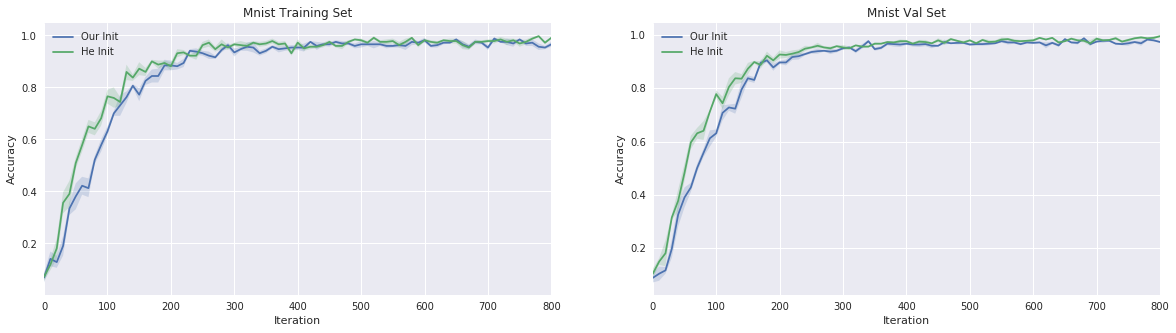

In [171]:
# Plot the results of the above tests with confidence intervals
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
sns.tsplot(data=our_init_results, time=xaxis, condition="Our Init")
sns.tsplot(data=he_init_results, time=xaxis, color="g", condition="He Init")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=our_init_results_val, time=xaxis, condition="Our Init")
sns.tsplot(data=he_init_results_val, time=xaxis, color="g", condition="He Init")

In [172]:
# TODO debug above, make it actually work well
# TODO (here) make CIFAR-10 dataset work and run sam test on this


In [173]:
# TODO print out results from the above


## Implementing R2WiderR and R2DeeperR

TODO: finish re-implementing everything (above) for cifar + CifarDataset

DONE: write more functions for widening of networks

DONE: implement resblock v2, subclassing v1, and have a widen operation + resnet v2

DONE: test widen operation (sanity checks inspecting weights)

DONE: implement resnet v3, with deepen operations

DONE: test deepen operation (sanity checks inspecting weights / IO operation)

TODO: implement resnet v3, version 2, where we replace ALL convolutions with R2R blocks, and see if it effects performance

TODO: test net2net operations: full capacity vs widen after x vs deepen after y. (May not be that good for mnist, cifar will be more interesting... implement cifar-10 now if haven't...) (actually, implement a thin mnist, which has num_channels = 2,4,6,8 through the layers... it shouldn't do well at all...)

TODO: with cifar-10, grid search for when to widen and when to deepen

TODO: plot the results for widen (deepen at time = 0)

TODO: plot the results for deepen (widen at time = 0)

TODO: plot the results for the top 5 models, and the worst 5 models

TODO: make a table (similar to assign3) of the results (END VALIDATION + TEST) (In latex math table style)

TODO: write up R2R, and now we're done with it!

TODO: (beginnings of the neuroevolution/inception resnet -> code up the convs/blocks/inception modules in a nice OOP way)
Start with: init_repeated, widen_in, widen_out, widen_in_out. Check all of them in similar ways (print output) and then delete the tests after confirming.

TODO: MORE ERROR CHECKING IN THE FINAL VERSIONS


What we're doing:
1. Implementing R2R_Residual_Block_v2, which implements a widen operation
 1. To implement this we need to rework the code to widnen a filter
 2. THen we just apply that appropriately to each R2R residual block
 3. Then we write a MNIST_resnet_v2, that implements a widen operation, just calling widen on all res blocks in the 
 4. Then we added deepen to the 

### Implementing Filter Widening Logic

Define functions to perform widening (at a tensor level)

In [174]:
def _zero_pad_1d(old_val, new_params):
    """
    Zero pads an old tensor to match the new number of outputs
    
    :param old_val the old torch tensor to zero pad
    :param new_params: the number of new params needed
    :return: a new, padded tensor
    """
    old_len = old_val.size()[0]
    canvas = t.zeros((old_len+new_params,))
    canvas[:old_len] = old_val
    return canvas



def _one_pad_1d(old_val, new_params):
    """
    One pads an old tensor to match the new number of outputs
    
    :param old_val the old torch tensor to one pad
    :param new_params: the number of new params needed
    :return: a new, padded tensor
    """
    old_len = old_val.size()[0]
    canvas = t.ones((old_len+new_params,))
    canvas[:old_len] = old_val
    return canvas



def _widen_kernel_with_repeated_in_repeated_output(old_kernel, old_bias, extra_in_channels=0, 
                                                   extra_out_channels=0, repeated_in=True, 
                                                   repeated_out=True, init_type='He'):
    """
    A revised version of the logic to widen a kernel. We pass in the old kernel, the number of channels 
    extended in a convolution before it (zero if the convolution before it hasn't been widened), and 
    the number of new channels for the output.
    
    If the old shape was [Ou,I,W,H] and the new shape is [Ou2,I2,W,H], so Ou2 is the new number of output 
    channels and Ou is the old number of output channels, when we initialize as follows:
    
    Letting hOu = (Ou2-Ou)/2
    and hI = (I2-I)/2
    and r1, r2, r3 are appropriately randomly initialized 
    
        In \ Out |      0:Ou      |    Ou:Ou+hOu    |   Ou+hOu:Ou2    
        -------------------------------------------------------------
             0:I |  old[0:Ou,0:I] |  r1[0:hOu,0:I]  |  r1[0:hOu,0:I]  
        -------------------------------------------------------------       
          I:I+hI |  r2[0:Ou,0:hI] |  r3[0:hOu,0:hI] |  r3[0:hOu,0:hI] 
        -------------------------------------------------------------
         I+hI:I2 | -r2[0:Ou,0:hI] | -r3[0:hOu,0:hI] | -r3[0:hOu,0:hI]   
         
         
    Note, if we change either repeated_input or repeated_output, then, we no longer have a function preserving
    transfom. And we ignore the above grid.
    
    :param old_kernel: the old kernel of the convolution layer (of shape (A,B,W,H))
    :param old_bias: the old bias of the convolution layer (of shape (A,))
    :param extra_in_channels: the number of new channels being input to this layer (A2-A)
    :param extra_out_channels: the number of new channels being output from this layer (B2-B)
    :param repeated_in: if we want to handle repeated input (of NEW input channels)
    :param repeated_out: if we want to make the NEW output channels repeated 
    :param init_type: The type of initialization to use for the kernel
    :return: A new, larger filter and bias. (Initialized appropriately for a function preserving transform)
    """
    if extra_in_channels % 2 != 0 or extra_out_channels % 2 != 0:
            # TODO: log an appropraite error message
            raise Exception()
    
    # compute values related to kernel size
    Ou, I, W, H = old_kernel.size()
    hOu = extra_out_channels // 2
    hI = extra_in_channels // 2
    total_new_in_channels = I + extra_in_channels
    total_new_out_channels = Ou + extra_out_channels
    
    # init function
    init = None
    if init_type == "He":
        init = lambda shape: t.tensor(_conv_he_initialize(shape, total_new_in_channels, total_new_out_channels))
    elif init_type == "Xavier":
        init = lambda shape: t.tensor(_conv_xavier_initialize(shape, total_new_in_channels, total_new_out_channels))
    
    # compute r1, r2, r3 as above.
    if hOu > 0:
        r1 = init((hOu,  I, W, H)) 
    if hI > 0:
        r2 = init(( Ou, hI, W, H))
    if hOu > 0 and hI > 0:
        r3 = init((hOu, hI, W, H))
    
    # make a canvas and fill it appropriately
    # ignore repetitions appropriately if either negate_repeated_new_input, repeat_new_output is false
    canvas = t.zeros((total_new_out_channels, total_new_in_channels, W, H))
    
    # top left four squares
    canvas[:Ou, :I] = old_kernel
    if hOu > 0:
        canvas[Ou:Ou+hOu, :I] = r1
    if hI > 0:
        canvas[:Ou, I:I+hI] = r2
    if hOu > 0 and hI > 0:
        canvas[Ou:Ou+hOu, I:I+hI] = r3
    
    # bottom left two squares
    if hI > 0:
         canvas[:Ou, I+hI:I+2*hI] = -r2 if repeated_in else init((Ou, hI, W, H))
    if hOu > 0 and hI > 0:
        canvas[Ou:Ou+hOu, I+hI:I+2*hI] = -r3 if repeated_in else init((hOu, hI, W, H))
        
    # right three squares    
    if hOu > 0:
        canvas[Ou+hOu:Ou+2*hOu] = canvas[Ou:Ou+hOu] if repeated_out else init((hOu, I+2*hI, W, H))
        
    # Bias just needs to be zero padded appropriately
    return canvas, _zero_pad_1d(old_bias, extra_out_channels)



# def _widen_kernel_with_repreated_in(old_kernel, old_bias, extra_input_channels, init_type='He'):
#     """
#     Code for repeated_in and repreated_out breaks if one of the values is zero. 
#     So for just repeated in, can't just pass in a zero, and have to 
#     """



# def _widen_kernel_with_repeated_out(old_kernel, old_bias, extra_output_channels, init_type='He'):
#     """
#     This just passes off to the widen function we've already written, and combines is with extending the bias
#     This extends the filter, assuming a FIXED input size, to increase the number of output filters
    
#     :param: 
    
#     :param old_kernel: the old kernel of the convolution layer
#     :param old_bias: the old bias of the convolution layer 
#     :param extra_output_channels: the number of new channels being output from this layer
#     :param init_type: The type of init to use for the initialization
#     :return: The new kernel, same as the old, with more output filters (repeated as needed for a function preserving transform)
#     """
#     if extra_output_channels % 2 != 0:
#             # TODO: log an appropraite error message
#             raise Exception()
            
#     # compute values related to kernel size
#     Ou, I, W, H = old_kernel.size()
#     total_new_in_channels = I + extra_in_channels
#     total_new_out_channels = Ou + extra_out_channels
#     extending_filder_shape = (total_new_out_channels, total_new_in_channels, W, H)
    
#     # make new kernel and bias
#     new_kernel = _init_filter_with_repeated_output(extending_filter_shape, 
#                                                    existing_filter=old_kernel.numpy(), 
#                                                    init_type=init_type)
#     new_kernel = t.tensor(new_kernel)
#     new_bias = _pad_bias(old_bias, total_new_out_channels)
    
#     return new_kernel, new_bias

### Implementing R2WiderR, within R2R_residual_block_v2

Make R2R_residual_block v2, that makes use of the filter widening functions written above. v2 subclasses v1, and adds a widen operation

In [175]:
class R2R_residual_block_v2(R2R_residual_block_v1):
    """
    A small residual block to be used for mnist/cifar10 tests.
    
    Extends v1, and adds a widen operation.
    """
    def __init__(self, input_channels, output_channels, identity_initialize=True, noise_ratio=1.0e-8):
        """
        Pass off to the superclass initializer
        """
        super(R2R_residual_block_v2, self).__init__(input_channels, output_channels, identity_initialize, noise_ratio)
        
        
    def widen(self, num_channels, function_preserving=True):
        """
        Widens the network appropriately (widens each of the filters). This is slightly hacky, as really 
        we want to call self.r2r.widen() rather than manipulating the r2r block ourselves. We will do this 
        in the final version.
        
        :param num_channels: The number of channels to add to every 
        :param function_preserving: If the widen should be a function preserving transform
        """ 
        # update new conv variable 
        self.conv1 = self._extend_conv(self.conv1, 0, num_channels, function_preserving) # don't extend input!
        self.conv2 = self._extend_conv(self.conv2, num_channels, num_channels, function_preserving)
        self.r2r.conv = self._extend_conv(self.r2r.conv, num_channels, num_channels, function_preserving)
        self.r2r.reduction = self._extend_conv(self.r2r.reduction, num_channels, 0, function_preserving, # don't extend output!
                                               kernel_size=1, padding=0)
        
        # update new bn variables
        self.bn1 = self._extend_batch_norm(self.bn1, num_channels)
        self.bn2 = self._extend_batch_norm(self.bn2, num_channels)
        self.r2r.batch_norm = self._extend_batch_norm(self.r2r.batch_norm, num_channels)
    
    
    def _extend_conv(self, conv, extra_channels_in=0, extra_channels_out=0, function_preserving=True, kernel_size=3, padding=1):
        """
        Combines all of the logic to extend conv, new convolution module. We create a new conv module, and 
        initialize it so that the filter is appropriately 'extended' from the old convolution module, 
        appropriately implementing the widening transform
        
        :param conv: The nn.Module convolution subclass instance to extend
        :param extra_channels_in: The number of extra channels in when widening the convolution
        :param extra_channels_out: The number of extra channels out when widening the convolution
        :param function_preserving: Should the convolution be extended in such a way that it preserves the function
        :returns: A new convolution, which is the result of this widen transform
        """
        # make the new conv module
        new_conv = nn.Conv2d(conv.in_channels+extra_channels_in, 
                             conv.out_channels+extra_channels_out, 
                             kernel_size=kernel_size, 
                             padding=padding)
        
        # shorthand, for long function name
        widen = _widen_kernel_with_repeated_in_repeated_output
        
        # Compute and assign the new kernel and bias
        new_kernel, new_bias = widen(old_kernel = conv.weight.data, 
                                     old_bias = conv.bias.data, 
                                     extra_in_channels = extra_channels_in,
                                     extra_out_channels = extra_channels_out,
                                     repeated_in=function_preserving, 
                                     repeated_out=function_preserving)
        new_conv.weight.data = Parameter(new_kernel)
        new_conv.bias.data = Parameter(new_bias)
        
        return new_conv
    
        
    def _extend_batch_norm(self, bn, num_channels):
        """
        Combines all of the logic to IN PLACE extend the 'bn' batch norm nn.Module appropriately to 
        extend a batch norm layer, and reset all of it's params appropriately for the widening transform.
        
        :param bn: The nn.Module batch norm subclass instance to extend
        :param num_channels: The number of extra channels (input and output) from this layer
        """
        # new batch norm module
        new_bn = nn.BatchNorm2d(num_features=bn.num_features + num_channels)
        
        # Zero/One pad the each of the sets of parameters maintained by batch norm layers appropriately
        new_scale = _one_pad_1d(bn.weight.data, num_channels)
        new_shift = _zero_pad_1d(bn.bias.data, num_channels)
        new_running_mean = _zero_pad_1d(bn.running_mean.data, num_channels)
        new_running_var = _zero_pad_1d(bn.running_var.data, num_channels)
        
        # Assign in the Module appropriately
        new_bn.weight.data = Parameter(new_scale)
        new_bn.bias.data = Parameter(new_shift)
        new_bn.running_mean.data = Parameter(new_running_mean)
        new_bn.running_var.data = Parameter(new_running_var)
        
        return new_bn
        
        

### Define the Mnist_Resnet_v2, using the v2 residual blocks

This includes a widen function, that just calls widen on all of the R2R_residual_block v2's. We provide a flag 'thin', which we should use to make a thinner network, which when widened, will be the same size. This isn't coded particularly elegantly, but it's just a trial run.

Note that there's a lot of things that we wouldn't want in a final implementation. Such as not being able to specify how much to widen the network by

In [176]:
class Mnist_Resnet_v2(nn.Module):
    def __init__(self, identity_initialize=True, thin=False, noise_ratio=1.0e-8):
        # Superclass initializer
        super(Mnist_Resnet_v2, self).__init__()
        
        # Make the three conv layers, with three max pools
        i, o = (1, 16) if not thin else (1, 8)
        self.resblock1 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]     
        i, o = (16, 32) if not thin else (8, 16)
        self.resblock2 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]
        i, o = (32, 64) if not thin else (16, 32)
        self.resblock3 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.final_conv_channels = 64 if not thin else 32
        self.linear1 = nn.Linear(4*4*self.final_conv_channels, 256)
        self.linear2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        x = self.resblock3(x)
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*self.final_conv_channels))
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x
    
    def widen(self):
        self.resblock1.widen(8)
        self.resblock2.widen(16)
        self.resblock3.widen(32)
 

### Sanity checks for the widen transform

In [177]:
# Make a mnist resnet v2
model = Mnist_Resnet_v2(thin=True, noise_ratio=0.0)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen and check that the outputs are (almost) identical
model.widen()
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: -0.000000
Average output difference before and after widen is: -0.000000
Params in model before widen: 165826
Params in model after widen: 246082


### Testing the widen transfrom on mnist, and evaluating it

Extend the evaluate function to take an iteration number to call deepen/widen on the model. Then run evaluate on the thin version of Mnist Resnet v2, and the widen after a few training iterations. We compare this against just the normal training of Mnist to see how it does.

In [178]:
# Evaluate a model
def evaluate(model, dataset, widen=-1, deepen=-1):
    # Setup bookeeping and optimizer
    train_iters = 800
    epoch_len = 10
    train_accuracies = []
    val_accuracies = []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
    
    # train for 300 iterations, evaluating every epoch
    for i in range(train_iters+1):
        # if need to widen/deepen, apply the R2R transform
        if i ==  widen:
            model.widen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
        if i == deepen: 
            model.deepen()
            optimizer = t.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
            
        # compute loss
        xs, ys = dataset.next_batch(64)
        ys_pred = model(xs)
        loss = loss_fn(ys_pred, ys)
        
        # make a step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # log at the beginning/end of every epoch
        if i % epoch_len == 0:
            train_acc = accuracy(ys_pred, ys)
            
            xs, ys = dataset.next_val_batch(128)
            ys_pred = model(xs)            
            val_acc = accuracy(ys_pred, ys)

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            print("(Iter %d). Current train: %0.6f, Current val: %0.6f." % (i, train_acc, val_acc))
            
    return train_accuracies, val_accuracies

In [185]:
# run our init, with widen at 60,120,180,240 iters
widen_results = {}
widen_results_val = {}
widen_times = {}

dataset = DatasetCudaWrapper(MnistDataset(64))

for widen in [60,120,180,240]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Mnist_Resnet_v2(thin=True)
        model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, widen=widen)
        elapsed_time = time.time() - start_time
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    widen_results[widen] = results
    widen_results_val[widen]= results_val
    widen_times[widen] = (np.mean(times), np.std(times))

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.218750, Current val: 0.101562.
(Iter 10). Current train: 0.046875, Current val: 0.101562.
(Iter 20). Current train: 0.078125, Current val: 0.109375.
(Iter 30). Current train: 0.140625, Current val: 0.085938.
(Iter 40). Current train: 0.031250, Current val: 0.125000.
(Iter 50). Current train: 0.218750, Current val: 0.265625.
(Iter 60). Current train: 0.281250, C

(Iter 460). Current train: 0.890625, Current val: 0.976562.
(Iter 470). Current train: 0.937500, Current val: 0.976562.
(Iter 480). Current train: 0.937500, Current val: 0.976562.
(Iter 490). Current train: 0.937500, Current val: 0.945312.
(Iter 500). Current train: 0.953125, Current val: 0.945312.
(Iter 510). Current train: 0.968750, Current val: 0.976562.
(Iter 520). Current train: 0.984375, Current val: 0.953125.
(Iter 530). Current train: 0.937500, Current val: 0.960938.
(Iter 540). Current train: 0.968750, Current val: 0.960938.
(Iter 550). Current train: 0.968750, Current val: 0.960938.
(Iter 560). Current train: 0.937500, Current val: 0.984375.
(Iter 570). Current train: 0.968750, Current val: 1.000000.
(Iter 580). Current train: 0.984375, Current val: 0.984375.
(Iter 590). Current train: 0.968750, Current val: 0.968750.
(Iter 600). Current train: 0.968750, Current val: 0.937500.
(Iter 610). Current train: 0.953125, Current val: 0.960938.
(Iter 620). Current train: 0.968750, Cur

(Iter 210). Current train: 0.937500, Current val: 0.937500.
(Iter 220). Current train: 0.937500, Current val: 0.898438.
(Iter 230). Current train: 0.906250, Current val: 0.960938.
(Iter 240). Current train: 0.890625, Current val: 0.945312.
(Iter 250). Current train: 0.906250, Current val: 0.937500.
(Iter 260). Current train: 0.937500, Current val: 0.945312.
(Iter 270). Current train: 0.875000, Current val: 0.984375.
(Iter 280). Current train: 0.984375, Current val: 0.953125.
(Iter 290). Current train: 0.937500, Current val: 0.914062.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.921875, Current val: 0.976562.
(Iter 320). Current train: 0.968750, Current val: 0.953125.
(Iter 330). Current train: 0.953125, Current val: 0.968750.
(Iter 340). Current train: 0.968750, Current val: 0.992188.
(Iter 350). Current train: 0.937500, Current val: 0.953125.
(Iter 360). Current train: 0.921875, Current val: 0.953125.
(Iter 370). Current train: 1.000000, Cur

(Iter 770). Current train: 1.000000, Current val: 1.000000.
(Iter 780). Current train: 0.953125, Current val: 0.960938.
(Iter 790). Current train: 0.968750, Current val: 0.976562.
(Iter 800). Current train: 0.984375, Current val: 0.976562.
(Iter 0). Current train: 0.125000, Current val: 0.070312.
(Iter 10). Current train: 0.062500, Current val: 0.078125.
(Iter 20). Current train: 0.156250, Current val: 0.085938.
(Iter 30). Current train: 0.078125, Current val: 0.093750.
(Iter 40). Current train: 0.140625, Current val: 0.140625.
(Iter 50). Current train: 0.062500, Current val: 0.101562.
(Iter 60). Current train: 0.390625, Current val: 0.382812.
(Iter 70). Current train: 0.375000, Current val: 0.562500.
(Iter 80). Current train: 0.515625, Current val: 0.445312.
(Iter 90). Current train: 0.500000, Current val: 0.476562.
(Iter 100). Current train: 0.593750, Current val: 0.617188.
(Iter 110). Current train: 0.468750, Current val: 0.531250.
(Iter 120). Current train: 0.406250, Current val: 0

(Iter 520). Current train: 0.968750, Current val: 0.968750.
(Iter 530). Current train: 0.984375, Current val: 0.937500.
(Iter 540). Current train: 0.984375, Current val: 0.914062.
(Iter 550). Current train: 0.953125, Current val: 0.984375.
(Iter 560). Current train: 0.984375, Current val: 0.984375.
(Iter 570). Current train: 0.984375, Current val: 0.976562.
(Iter 580). Current train: 0.968750, Current val: 0.953125.
(Iter 590). Current train: 0.937500, Current val: 0.976562.
(Iter 600). Current train: 0.953125, Current val: 0.960938.
(Iter 610). Current train: 0.953125, Current val: 0.960938.
(Iter 620). Current train: 0.968750, Current val: 0.976562.
(Iter 630). Current train: 0.875000, Current val: 0.984375.
(Iter 640). Current train: 0.953125, Current val: 0.968750.
(Iter 650). Current train: 0.968750, Current val: 0.960938.
(Iter 660). Current train: 0.937500, Current val: 0.953125.
(Iter 670). Current train: 0.937500, Current val: 0.968750.
(Iter 680). Current train: 0.984375, Cur

(Iter 270). Current train: 0.921875, Current val: 0.914062.
(Iter 280). Current train: 0.890625, Current val: 0.960938.
(Iter 290). Current train: 0.921875, Current val: 0.906250.
(Iter 300). Current train: 0.906250, Current val: 0.929688.
(Iter 310). Current train: 0.968750, Current val: 0.945312.
(Iter 320). Current train: 0.953125, Current val: 0.929688.
(Iter 330). Current train: 0.921875, Current val: 0.945312.
(Iter 340). Current train: 0.984375, Current val: 0.937500.
(Iter 350). Current train: 0.937500, Current val: 0.976562.
(Iter 360). Current train: 0.890625, Current val: 0.968750.
(Iter 370). Current train: 0.921875, Current val: 0.929688.
(Iter 380). Current train: 0.906250, Current val: 0.960938.
(Iter 390). Current train: 0.953125, Current val: 0.960938.
(Iter 400). Current train: 0.968750, Current val: 0.992188.
(Iter 410). Current train: 0.953125, Current val: 0.921875.
(Iter 420). Current train: 0.953125, Current val: 0.953125.
(Iter 430). Current train: 0.953125, Cur

(Iter 30). Current train: 0.140625, Current val: 0.109375.
(Iter 40). Current train: 0.125000, Current val: 0.132812.
(Iter 50). Current train: 0.203125, Current val: 0.296875.
(Iter 60). Current train: 0.265625, Current val: 0.289062.
(Iter 70). Current train: 0.375000, Current val: 0.390625.
(Iter 80). Current train: 0.312500, Current val: 0.468750.
(Iter 90). Current train: 0.312500, Current val: 0.429688.
(Iter 100). Current train: 0.453125, Current val: 0.445312.
(Iter 110). Current train: 0.468750, Current val: 0.523438.
(Iter 120). Current train: 0.578125, Current val: 0.468750.
(Iter 130). Current train: 0.437500, Current val: 0.500000.
(Iter 140). Current train: 0.640625, Current val: 0.671875.
(Iter 150). Current train: 0.593750, Current val: 0.625000.
(Iter 160). Current train: 0.718750, Current val: 0.656250.
(Iter 170). Current train: 0.687500, Current val: 0.664062.
(Iter 180). Current train: 0.703125, Current val: 0.757812.
(Iter 190). Current train: 0.765625, Current va

(Iter 590). Current train: 0.984375, Current val: 0.976562.
(Iter 600). Current train: 0.984375, Current val: 0.976562.
(Iter 610). Current train: 0.953125, Current val: 0.976562.
(Iter 620). Current train: 0.937500, Current val: 0.953125.
(Iter 630). Current train: 0.953125, Current val: 0.960938.
(Iter 640). Current train: 0.968750, Current val: 0.984375.
(Iter 650). Current train: 0.984375, Current val: 0.953125.
(Iter 660). Current train: 0.921875, Current val: 0.976562.
(Iter 670). Current train: 0.984375, Current val: 0.953125.
(Iter 680). Current train: 1.000000, Current val: 0.984375.
(Iter 690). Current train: 0.953125, Current val: 0.945312.
(Iter 700). Current train: 0.953125, Current val: 0.968750.
(Iter 710). Current train: 0.953125, Current val: 0.953125.
(Iter 720). Current train: 0.984375, Current val: 0.984375.
(Iter 730). Current train: 1.000000, Current val: 0.968750.
(Iter 740). Current train: 0.968750, Current val: 0.968750.
(Iter 750). Current train: 0.937500, Cur

(Iter 340). Current train: 0.937500, Current val: 0.945312.
(Iter 350). Current train: 0.921875, Current val: 0.937500.
(Iter 360). Current train: 0.984375, Current val: 0.968750.
(Iter 370). Current train: 0.906250, Current val: 0.960938.
(Iter 380). Current train: 0.937500, Current val: 0.968750.
(Iter 390). Current train: 0.968750, Current val: 0.968750.
(Iter 400). Current train: 0.984375, Current val: 0.984375.
(Iter 410). Current train: 0.937500, Current val: 0.945312.
(Iter 420). Current train: 0.937500, Current val: 0.945312.
(Iter 430). Current train: 0.968750, Current val: 0.945312.
(Iter 440). Current train: 0.953125, Current val: 0.960938.
(Iter 450). Current train: 0.968750, Current val: 0.984375.
(Iter 460). Current train: 0.953125, Current val: 0.953125.
(Iter 470). Current train: 0.984375, Current val: 0.937500.
(Iter 480). Current train: 0.968750, Current val: 0.960938.
(Iter 490). Current train: 0.953125, Current val: 0.984375.
(Iter 500). Current train: 0.953125, Cur

(Iter 90). Current train: 0.406250, Current val: 0.335938.
(Iter 100). Current train: 0.437500, Current val: 0.476562.
(Iter 110). Current train: 0.468750, Current val: 0.453125.
(Iter 120). Current train: 0.406250, Current val: 0.546875.
(Iter 130). Current train: 0.578125, Current val: 0.531250.
(Iter 140). Current train: 0.593750, Current val: 0.625000.
(Iter 150). Current train: 0.656250, Current val: 0.648438.
(Iter 160). Current train: 0.625000, Current val: 0.640625.
(Iter 170). Current train: 0.656250, Current val: 0.695312.
(Iter 180). Current train: 0.765625, Current val: 0.718750.
(Iter 190). Current train: 0.734375, Current val: 0.757812.
(Iter 200). Current train: 0.687500, Current val: 0.726562.
(Iter 210). Current train: 0.843750, Current val: 0.812500.
(Iter 220). Current train: 0.828125, Current val: 0.781250.
(Iter 230). Current train: 0.796875, Current val: 0.835938.
(Iter 240). Current train: 0.906250, Current val: 0.851562.
(Iter 250). Current train: 0.828125, Curr

(Iter 650). Current train: 0.984375, Current val: 0.960938.
(Iter 660). Current train: 0.984375, Current val: 0.984375.
(Iter 670). Current train: 0.984375, Current val: 0.984375.
(Iter 680). Current train: 0.968750, Current val: 0.992188.
(Iter 690). Current train: 0.953125, Current val: 0.953125.
(Iter 700). Current train: 0.968750, Current val: 0.960938.
(Iter 710). Current train: 0.968750, Current val: 0.976562.
(Iter 720). Current train: 0.984375, Current val: 0.960938.
(Iter 730). Current train: 0.968750, Current val: 0.984375.
(Iter 740). Current train: 0.953125, Current val: 0.953125.
(Iter 750). Current train: 0.921875, Current val: 0.976562.
(Iter 760). Current train: 0.968750, Current val: 0.976562.
(Iter 770). Current train: 0.921875, Current val: 0.976562.
(Iter 780). Current train: 0.953125, Current val: 0.953125.
(Iter 790). Current train: 0.921875, Current val: 0.968750.
(Iter 800). Current train: 0.968750, Current val: 0.960938.
(Iter 0). Current train: 0.171875, Curre

(Iter 400). Current train: 0.890625, Current val: 0.960938.
(Iter 410). Current train: 0.937500, Current val: 0.929688.
(Iter 420). Current train: 0.890625, Current val: 0.937500.
(Iter 430). Current train: 0.953125, Current val: 0.968750.
(Iter 440). Current train: 0.953125, Current val: 0.921875.
(Iter 450). Current train: 0.906250, Current val: 0.937500.
(Iter 460). Current train: 0.890625, Current val: 0.937500.
(Iter 470). Current train: 0.953125, Current val: 0.921875.
(Iter 480). Current train: 0.953125, Current val: 0.953125.
(Iter 490). Current train: 0.984375, Current val: 0.960938.
(Iter 500). Current train: 0.968750, Current val: 0.937500.
(Iter 510). Current train: 0.921875, Current val: 0.937500.
(Iter 520). Current train: 0.953125, Current val: 0.960938.
(Iter 530). Current train: 0.937500, Current val: 0.953125.
(Iter 540). Current train: 0.968750, Current val: 0.976562.
(Iter 550). Current train: 1.000000, Current val: 0.976562.
(Iter 560). Current train: 0.953125, Cur

### Plotting the results (with respect to number of updates) of using R2WiderR at different times

Note that this is NOT representative of how long the models took to train. Updates on the smaller models are MUCH quicker.

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


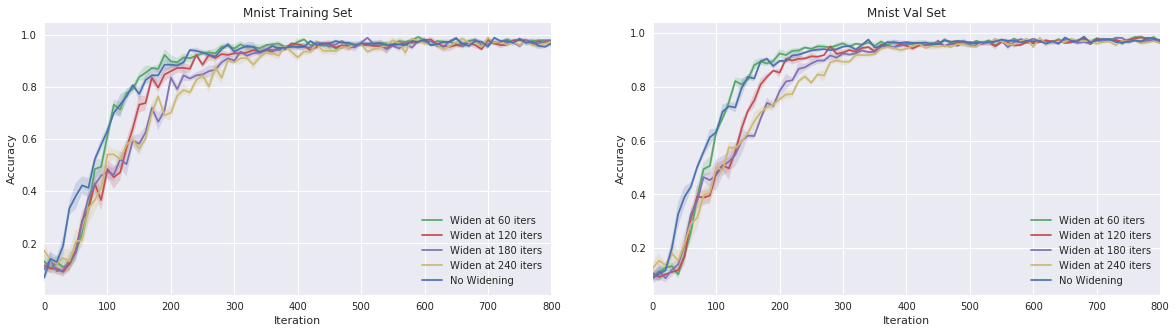

In [186]:
# Grab old results
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10
old_results = []
old_results_val = []
for i in range(len(our_init_results)):
    old_results.append(our_init_results[i][:81])
    old_results_val.append(our_init_results_val[i][:81])
    
# Plot results
plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=widen_results[60], time=xaxis, color=cp[1], condition="Widen at 60 iters")
sns.tsplot(data=widen_results[120], time=xaxis, color=cp[2], condition="Widen at 120 iters")
sns.tsplot(data=widen_results[180], time=xaxis, color=cp[3], condition="Widen at 180 iters")
sns.tsplot(data=widen_results[240], time=xaxis, color=cp[4], condition="Widen at 240 iters")
sns.tsplot(data=old_results, time=xaxis, color=cp[0], condition="No Widening")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=widen_results_val[60], time=xaxis, color=cp[1], condition="Widen at 60 iters")
sns.tsplot(data=widen_results_val[120], time=xaxis, color=cp[2], condition="Widen at 120 iters")
sns.tsplot(data=widen_results_val[180], time=xaxis, color=cp[3], condition="Widen at 180 iters")
sns.tsplot(data=widen_results_val[240], time=xaxis, color=cp[4], condition="Widen at 240 iters")
sns.tsplot(data=old_results_val, time=xaxis, color=cp[0], condition="No Widening")

### Initially implementing R2DeeperR, by (hacky) Mnist_Residual_Network_v3

We're going to alter the code from Mnist Residual Network v2. A hacky way to implement the deepen transform is to just keep all of the layers initialized at the start, and only use a subset of the layers before the "deepen" transform. Therefore, in this iteration, deepening the network will correspond to just setting a flag. (It will be more complex for the general Inception Resnet case, but not much, as it's still the same idea).

N.B. We changed this so that there's a noticable change in the number of parameters before and after the transform! But, it's the same either way that it's implemented. (Initializing it at the start is simpler, but, less demonstrative of the transform in the sanity check)

Because a 6 residual block (i.e. 18 layer) network is a little overkill for Mnist, we reduce it to just 2 residual blocks before the deepen, and 4 after.

In [187]:
class Mnist_Resnet_v3(nn.Module):
    def __init__(self, identity_initialize=True, thin=False, deeper=False, noise_ratio=1.0e-8):
        # Superclass initializer
        super(Mnist_Resnet_v3, self).__init__()
        
        # Variables to be able to widen properly & consistently. Deepen now if deeper==True
        self.thin = thin
        self.identity_initialize = identity_initialize
        self.deeper = deeper
        if self.deeper:
            self.deepen()
        
        # Make the three conv layers, with three max pools        
        i, o = (1, 16) if not thin else (1, 8)
        self.resblock1 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 16, 32, 32]
        self.pool1 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 16, 16, 16]  
        
        i, o = (16, 32) if not thin else (8, 16)
        self.resblock2 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=identity_initialize,
                                               noise_ratio=noise_ratio) # [-1, 32, 16, 16]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 32, 8, 8]  
        
#         i, o = (32, 64) if not thin else (16, 32)
#         self.resblock3 = R2R_residual_block_v2(input_channels=i, 
#                                                output_channels=o, 
#                                                identity_initialize=identity_initialize,
#                                                noise_ratio=noise_ratio) # [-1, 64, 8, 8]
        self.pool3 = nn.MaxPool2d(kernel_size=2)                                        # [-1, 64, 4, 4]
        
        # fully connected out
        self.final_conv_channels = 64 if not thin else 32
        self.linear1 = nn.Linear(4*4*self.final_conv_channels, 256)
        self.linear2 = nn.Linear(256, 10)
        
    
    def forward(self, x):
        # convs
        x = self.resblock1(x)
        x = self.pool1(x)
        x = self.resblock2(x)
        x = self.pool2(x)
        if self.deeper:
            x = self.resblock3(x)
        else:
            # if ignoring 3rd block, then make it an identity (v. hacky here...)
            buf_shape = x.size()
            buf_shape = (buf_shape[0], buf_shape[1]*2, buf_shape[2], buf_shape[3])
            buf = t.zeros(buf_shape)
            buf[:,:x.size()[1]] = x
            x = buf
            
        x = self.pool3(x)
        
        # fc
        x = x.view((-1, 4*4*self.final_conv_channels))
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x
    
    
    def widen(self):
        self.resblock1.widen(8)
        self.resblock2.widen(16)
        if self.deeper: 
            self.resblock3.widen(32)
        
        # so that deepen works correctly!
        self.thin = False
        
        
    def deepen(self):
        self.deeper = True
        
        i, o = (32, 64) if not self.thin else (16, 32)
        self.resblock3 = R2R_residual_block_v2(input_channels=i, 
                                               output_channels=o, 
                                               identity_initialize=self.identity_initialize) # [-1, 64, 8, 8]
 

### Sanity check, functions are identical before and after the deepen transform

Basically just a c&p from the check for the widen transform before. Note because of how we implemented the network, the number of parameters is the same before and after.

In [188]:
# Make a mnist resnet v3
model = Mnist_Resnet_v3(noise_ratio=0.0)
params_before = sum([np.prod(p.size()) for p in model.parameters()])

# store 10 random inputs, and their outputs
rand_ins = []
rand_outs = []
for _ in range(10):
    rand_in = t.Tensor(np.random.uniform(low=-1.0, high=1.0, size=(1,1,32,32)))
    rand_out = model(rand_in)
    rand_ins.append(rand_in)
    rand_outs.append(rand_out)

# widen and check that the outputs are (almost) identical
model.deepen()
params_after = sum([np.prod(p.size()) for p in model.parameters()])
for i in range(10):
    rand_out = model(rand_ins[i])
    print("Average output difference before and after widen is: %f" % t.mean(rand_out - rand_outs[i]))
    
print("Params in model before widen: %d" % params_before)
print("Params in model after widen: %d" % params_after)

Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Average output difference before and after widen is: 0.000000
Params in model before widen: 294522
Params in model after widen: 391418


### Sanity check using number of floating point operations

Here we compute the number of floating point operations for the forward pass of Mnist Resnet v1, and v3 after deepening and widening. v3 should have less or equal to v1.

In [189]:
from flops_utils import *

xs, _ = DatasetCudaWrapper(MnistDataset(32)).next_batch()

model = Mnist_Resnet_v3(thin=True)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
thin_shallow_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=True)
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
wide_shallow_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=True)
model.deepen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
thin_deep_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=True)
model.deepen()
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
wide_deep_flops = model.compute_average_flops_cost()

baseline_model = Mnist_Resnet_v1()
baseline_model = add_flops_counting_methods(baseline_model)
baseline_model.start_flops_count()

_ = baseline_model(xs)
baseline_flops = model.compute_average_flops_cost()

print("v1 flops: %d" % baseline_flops)
print("v3 thin, shallow flops: %d" % thin_shallow_flops)
print("v3 thin, deeper flops: %d" % thin_deep_flops)
print("v3 wider, shallow flops: %d" % wide_shallow_flops)
print("v3 wider, deeper flops: %d" % wide_deep_flops)

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
v1 flops: 31852544
v3 thin, shallow flops: 5767168
v3 thin, deeper flops: 8855552
v3 wider, shallow flops: 20959232
v3 wider, deeper flops: 31852544


### Plotting the results (with respect to number of updates) of using R2DeeperR at different times

We run the eval loop on many networks, calling the deepen() transform at differing stages of training to see what effect it has.

Note that this is NOT representative of how long the models took to train. Updates on the smaller models are MUCH quicker. So it will look like the smaller networks did worst, but, they actually trained quicker, hitting the same performance.

In [190]:
# run our init, with widen at 60,120,180,240 iters
deepen_results = {}
deepen_results_val = {}
deepen_times = {}

dataset = DatasetCudaWrapper(MnistDataset(64))

for deepen in [60,120,180,240]:
    results = []
    results_val = []
    times = []
    
    for i in range(5):
        model = Mnist_Resnet_v3(thin=False)
        model = model.cuda()
        start_time = time.time()
        train_acc, val_acc = evaluate(model, dataset, deepen=deepen)
        elapsed_time = time.time() - start_time
        
        results.append(train_acc)
        results_val.append(val_acc)
        times.append(elapsed_time)
        
    deepen_results[deepen] = results
    deepen_results_val[deepen] = results_val
    deepen_times[deepen] = (np.mean(times), np.std(times))

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz
(Iter 0). Current train: 0.125000, Current val: 0.156250.
(Iter 10). Current train: 0.265625, Current val: 0.109375.
(Iter 20). Current train: 0.046875, Current val: 0.101562.
(Iter 30). Current train: 0.078125, Current val: 0.085938.
(Iter 40). Current train: 0.281250, Current val: 0.242188.
(Iter 50). Current train: 0.343750, Current val: 0.265625.
(Iter 60). Current train: 0.140625, C

(Iter 460). Current train: 0.921875, Current val: 0.953125.
(Iter 470). Current train: 0.968750, Current val: 0.968750.
(Iter 480). Current train: 0.984375, Current val: 0.960938.
(Iter 490). Current train: 0.984375, Current val: 0.984375.
(Iter 500). Current train: 0.953125, Current val: 0.968750.
(Iter 510). Current train: 0.953125, Current val: 0.968750.
(Iter 520). Current train: 0.984375, Current val: 0.984375.
(Iter 530). Current train: 1.000000, Current val: 0.960938.
(Iter 540). Current train: 0.968750, Current val: 0.976562.
(Iter 550). Current train: 0.953125, Current val: 0.968750.
(Iter 560). Current train: 0.968750, Current val: 0.960938.
(Iter 570). Current train: 0.953125, Current val: 0.992188.
(Iter 580). Current train: 0.968750, Current val: 0.953125.
(Iter 590). Current train: 0.953125, Current val: 0.968750.
(Iter 600). Current train: 1.000000, Current val: 0.984375.
(Iter 610). Current train: 0.953125, Current val: 0.992188.
(Iter 620). Current train: 1.000000, Cur

(Iter 210). Current train: 0.906250, Current val: 0.921875.
(Iter 220). Current train: 0.984375, Current val: 0.960938.
(Iter 230). Current train: 0.921875, Current val: 0.890625.
(Iter 240). Current train: 0.937500, Current val: 0.929688.
(Iter 250). Current train: 0.968750, Current val: 0.968750.
(Iter 260). Current train: 1.000000, Current val: 0.953125.
(Iter 270). Current train: 0.968750, Current val: 0.968750.
(Iter 280). Current train: 0.921875, Current val: 0.960938.
(Iter 290). Current train: 0.859375, Current val: 0.937500.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.937500, Current val: 0.984375.
(Iter 320). Current train: 0.953125, Current val: 0.906250.
(Iter 330). Current train: 0.984375, Current val: 0.937500.
(Iter 340). Current train: 0.906250, Current val: 0.960938.
(Iter 350). Current train: 0.953125, Current val: 0.968750.
(Iter 360). Current train: 0.953125, Current val: 0.945312.
(Iter 370). Current train: 0.921875, Cur

(Iter 770). Current train: 0.968750, Current val: 0.984375.
(Iter 780). Current train: 0.968750, Current val: 0.960938.
(Iter 790). Current train: 0.953125, Current val: 0.968750.
(Iter 800). Current train: 1.000000, Current val: 0.976562.
(Iter 0). Current train: 0.046875, Current val: 0.031250.
(Iter 10). Current train: 0.046875, Current val: 0.085938.
(Iter 20). Current train: 0.125000, Current val: 0.101562.
(Iter 30). Current train: 0.156250, Current val: 0.195312.
(Iter 40). Current train: 0.156250, Current val: 0.195312.
(Iter 50). Current train: 0.234375, Current val: 0.156250.
(Iter 60). Current train: 0.218750, Current val: 0.218750.
(Iter 70). Current train: 0.140625, Current val: 0.289062.
(Iter 80). Current train: 0.515625, Current val: 0.484375.
(Iter 90). Current train: 0.609375, Current val: 0.515625.
(Iter 100). Current train: 0.500000, Current val: 0.406250.
(Iter 110). Current train: 0.593750, Current val: 0.710938.
(Iter 120). Current train: 0.593750, Current val: 0

(Iter 520). Current train: 0.968750, Current val: 0.976562.
(Iter 530). Current train: 0.937500, Current val: 0.976562.
(Iter 540). Current train: 0.984375, Current val: 0.984375.
(Iter 550). Current train: 1.000000, Current val: 0.968750.
(Iter 560). Current train: 1.000000, Current val: 0.976562.
(Iter 570). Current train: 1.000000, Current val: 0.984375.
(Iter 580). Current train: 0.984375, Current val: 0.953125.
(Iter 590). Current train: 0.968750, Current val: 0.968750.
(Iter 600). Current train: 0.984375, Current val: 0.968750.
(Iter 610). Current train: 0.968750, Current val: 0.953125.
(Iter 620). Current train: 0.953125, Current val: 0.992188.
(Iter 630). Current train: 0.984375, Current val: 0.968750.
(Iter 640). Current train: 0.968750, Current val: 0.976562.
(Iter 650). Current train: 0.984375, Current val: 0.976562.
(Iter 660). Current train: 1.000000, Current val: 0.992188.
(Iter 670). Current train: 0.968750, Current val: 0.968750.
(Iter 680). Current train: 1.000000, Cur

(Iter 270). Current train: 0.968750, Current val: 0.953125.
(Iter 280). Current train: 0.937500, Current val: 0.953125.
(Iter 290). Current train: 0.906250, Current val: 0.953125.
(Iter 300). Current train: 0.968750, Current val: 0.953125.
(Iter 310). Current train: 0.953125, Current val: 0.960938.
(Iter 320). Current train: 0.953125, Current val: 0.937500.
(Iter 330). Current train: 0.937500, Current val: 0.960938.
(Iter 340). Current train: 0.984375, Current val: 0.945312.
(Iter 350). Current train: 0.921875, Current val: 0.945312.
(Iter 360). Current train: 0.953125, Current val: 0.945312.
(Iter 370). Current train: 0.968750, Current val: 0.929688.
(Iter 380). Current train: 0.984375, Current val: 0.976562.
(Iter 390). Current train: 0.937500, Current val: 0.984375.
(Iter 400). Current train: 1.000000, Current val: 0.937500.
(Iter 410). Current train: 0.921875, Current val: 0.937500.
(Iter 420). Current train: 0.953125, Current val: 0.953125.
(Iter 430). Current train: 0.984375, Cur

(Iter 20). Current train: 0.203125, Current val: 0.125000.
(Iter 30). Current train: 0.187500, Current val: 0.226562.
(Iter 40). Current train: 0.187500, Current val: 0.125000.
(Iter 50). Current train: 0.171875, Current val: 0.187500.
(Iter 60). Current train: 0.218750, Current val: 0.195312.
(Iter 70). Current train: 0.296875, Current val: 0.320312.
(Iter 80). Current train: 0.359375, Current val: 0.375000.
(Iter 90). Current train: 0.312500, Current val: 0.398438.
(Iter 100). Current train: 0.562500, Current val: 0.500000.
(Iter 110). Current train: 0.578125, Current val: 0.453125.
(Iter 120). Current train: 0.484375, Current val: 0.500000.
(Iter 130). Current train: 0.531250, Current val: 0.500000.
(Iter 140). Current train: 0.515625, Current val: 0.648438.
(Iter 150). Current train: 0.656250, Current val: 0.625000.
(Iter 160). Current train: 0.640625, Current val: 0.687500.
(Iter 170). Current train: 0.750000, Current val: 0.734375.
(Iter 180). Current train: 0.718750, Current val

(Iter 580). Current train: 1.000000, Current val: 0.960938.
(Iter 590). Current train: 0.984375, Current val: 0.984375.
(Iter 600). Current train: 0.968750, Current val: 0.984375.
(Iter 610). Current train: 0.968750, Current val: 0.953125.
(Iter 620). Current train: 0.968750, Current val: 0.992188.
(Iter 630). Current train: 0.953125, Current val: 0.968750.
(Iter 640). Current train: 0.984375, Current val: 0.992188.
(Iter 650). Current train: 0.984375, Current val: 0.992188.
(Iter 660). Current train: 0.968750, Current val: 0.992188.
(Iter 670). Current train: 0.968750, Current val: 0.992188.
(Iter 680). Current train: 0.984375, Current val: 0.976562.
(Iter 690). Current train: 0.984375, Current val: 0.968750.
(Iter 700). Current train: 0.953125, Current val: 0.984375.
(Iter 710). Current train: 0.968750, Current val: 0.976562.
(Iter 720). Current train: 0.984375, Current val: 0.953125.
(Iter 730). Current train: 0.984375, Current val: 0.968750.
(Iter 740). Current train: 1.000000, Cur

(Iter 330). Current train: 0.984375, Current val: 0.953125.
(Iter 340). Current train: 0.968750, Current val: 0.914062.
(Iter 350). Current train: 0.890625, Current val: 0.937500.
(Iter 360). Current train: 0.968750, Current val: 0.921875.
(Iter 370). Current train: 0.937500, Current val: 0.937500.
(Iter 380). Current train: 0.906250, Current val: 0.914062.
(Iter 390). Current train: 0.921875, Current val: 0.937500.
(Iter 400). Current train: 0.890625, Current val: 0.921875.
(Iter 410). Current train: 0.890625, Current val: 0.976562.
(Iter 420). Current train: 0.968750, Current val: 0.968750.
(Iter 430). Current train: 0.953125, Current val: 0.976562.
(Iter 440). Current train: 0.968750, Current val: 0.968750.
(Iter 450). Current train: 0.921875, Current val: 0.921875.
(Iter 460). Current train: 0.968750, Current val: 0.945312.
(Iter 470). Current train: 0.937500, Current val: 0.953125.
(Iter 480). Current train: 0.968750, Current val: 0.968750.
(Iter 490). Current train: 0.937500, Cur

(Iter 80). Current train: 0.437500, Current val: 0.468750.
(Iter 90). Current train: 0.562500, Current val: 0.515625.
(Iter 100). Current train: 0.703125, Current val: 0.609375.
(Iter 110). Current train: 0.593750, Current val: 0.625000.
(Iter 120). Current train: 0.609375, Current val: 0.531250.
(Iter 130). Current train: 0.484375, Current val: 0.625000.
(Iter 140). Current train: 0.687500, Current val: 0.632812.
(Iter 150). Current train: 0.640625, Current val: 0.679688.
(Iter 160). Current train: 0.734375, Current val: 0.679688.
(Iter 170). Current train: 0.750000, Current val: 0.789062.
(Iter 180). Current train: 0.765625, Current val: 0.765625.
(Iter 190). Current train: 0.828125, Current val: 0.796875.
(Iter 200). Current train: 0.859375, Current val: 0.843750.
(Iter 210). Current train: 0.875000, Current val: 0.812500.
(Iter 220). Current train: 0.828125, Current val: 0.851562.
(Iter 230). Current train: 0.859375, Current val: 0.906250.
(Iter 240). Current train: 0.843750, Curre

(Iter 640). Current train: 0.968750, Current val: 0.929688.
(Iter 650). Current train: 0.937500, Current val: 0.968750.
(Iter 660). Current train: 0.984375, Current val: 0.992188.
(Iter 670). Current train: 0.984375, Current val: 0.984375.
(Iter 680). Current train: 0.953125, Current val: 0.992188.
(Iter 690). Current train: 1.000000, Current val: 0.937500.
(Iter 700). Current train: 0.937500, Current val: 0.984375.
(Iter 710). Current train: 0.984375, Current val: 1.000000.
(Iter 720). Current train: 1.000000, Current val: 0.976562.
(Iter 730). Current train: 0.937500, Current val: 0.976562.
(Iter 740). Current train: 0.968750, Current val: 0.976562.
(Iter 750). Current train: 0.968750, Current val: 0.960938.
(Iter 760). Current train: 0.984375, Current val: 0.968750.
(Iter 770). Current train: 0.968750, Current val: 0.968750.
(Iter 780). Current train: 0.921875, Current val: 0.968750.
(Iter 790). Current train: 0.984375, Current val: 0.984375.
(Iter 800). Current train: 0.968750, Cur

(Iter 390). Current train: 0.937500, Current val: 0.968750.
(Iter 400). Current train: 0.906250, Current val: 0.914062.
(Iter 410). Current train: 0.921875, Current val: 0.953125.
(Iter 420). Current train: 0.937500, Current val: 0.937500.
(Iter 430). Current train: 0.906250, Current val: 0.921875.
(Iter 440). Current train: 0.953125, Current val: 0.953125.
(Iter 450). Current train: 0.953125, Current val: 0.976562.
(Iter 460). Current train: 0.984375, Current val: 0.937500.
(Iter 470). Current train: 0.937500, Current val: 0.968750.
(Iter 480). Current train: 0.984375, Current val: 0.945312.
(Iter 490). Current train: 0.953125, Current val: 0.914062.
(Iter 500). Current train: 0.906250, Current val: 0.976562.
(Iter 510). Current train: 0.984375, Current val: 0.968750.
(Iter 520). Current train: 0.937500, Current val: 0.953125.
(Iter 530). Current train: 0.953125, Current val: 0.953125.
(Iter 540). Current train: 0.984375, Current val: 0.968750.
(Iter 550). Current train: 0.953125, Cur

/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


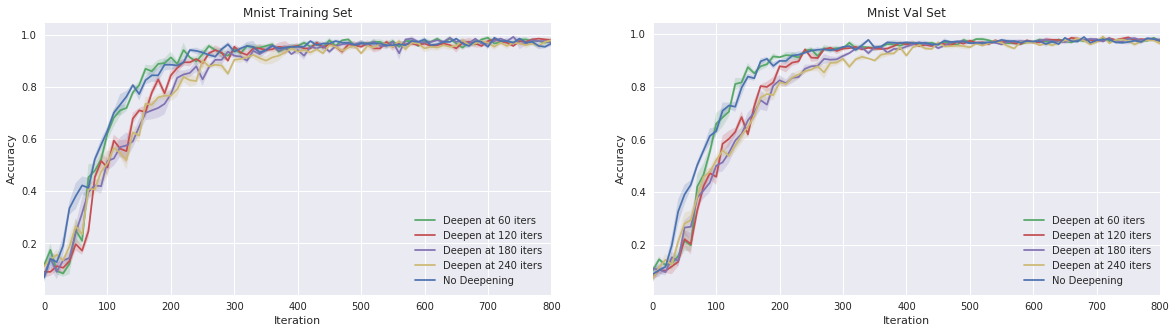

In [191]:
# Plot results
plt.figure(figsize=(20,5))
plt.tight_layout()

xaxis = np.array(range(81)) * 10

plt.subplot(121)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=xaxis, color=cp[1], condition="Deepen at 60 iters")
sns.tsplot(data=deepen_results[120], time=xaxis, color=cp[2], condition="Deepen at 120 iters")
sns.tsplot(data=deepen_results[180], time=xaxis, color=cp[3], condition="Deepen at 180 iters")
sns.tsplot(data=deepen_results[240], time=xaxis, color=cp[4], condition="Deepen at 240 iters")
sns.tsplot(data=old_results, time=xaxis, color=cp[0], condition="No Deepening")
plt.legend()

plt.subplot(122)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=deepen_results_val[60], time=xaxis, color=cp[1], condition="Deepen at 60 iters")
sns.tsplot(data=deepen_results_val[120], time=xaxis, color=cp[2], condition="Deepen at 120 iters")
sns.tsplot(data=deepen_results_val[180], time=xaxis, color=cp[3], condition="Deepen at 180 iters")
sns.tsplot(data=deepen_results_val[240], time=xaxis, color=cp[4], condition="Deepen at 240 iters")
sns.tsplot(data=old_results_val, time=xaxis, color=cp[0], condition="No Deepening")

### The more interesting results. Training with respect to the number of FLOPs.

We now compute the number of FLOPs used to reach each training point, and scale the x axis appropriately. This is more representative of what the time taken to train these models.

Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/mp/231n/Deep-Neuroevolution-With-SharedWeights---Ensembling-A-Better-Solution/experiments/dataset/data/mnist/t10k-labels-idx1-ubyte.gz


/anaconda/envs/cs231n/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


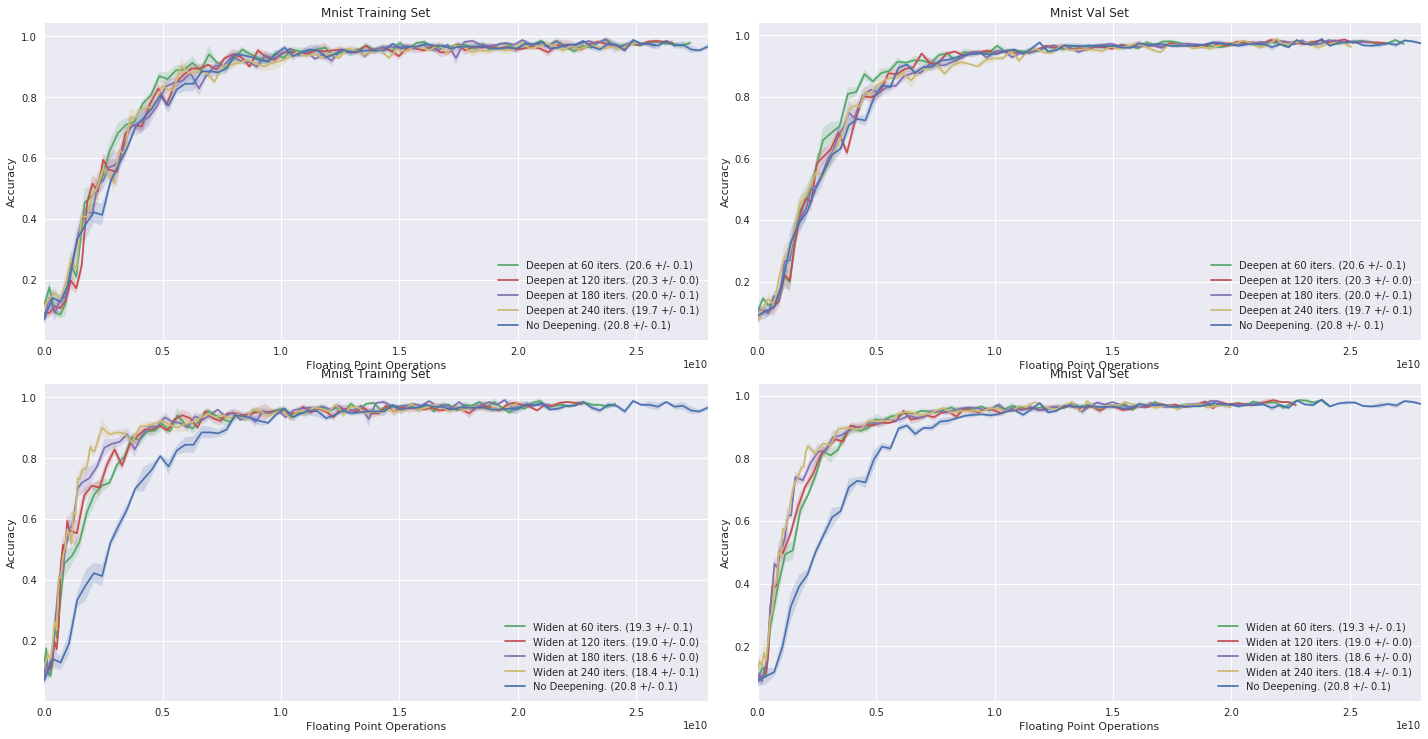

In [197]:
from flops_utils import *

dataset = DatasetCudaWrapper(MnistDataset(64))
xs, _ = dataset.next_batch(64)

model = Mnist_Resnet_v3(thin=False)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
pre_deepen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v3(thin=False)
model.deepen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
post_deepen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v2(thin=True)
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
pre_widen_flops = model.compute_average_flops_cost()

model = Mnist_Resnet_v2(thin=True)
model.widen()
model = add_flops_counting_methods(model)
model.start_flops_count()

_ = model(xs)
post_widen_flops = model.compute_average_flops_cost()

baseline_model = Mnist_Resnet_v1()
baseline_model = add_flops_counting_methods(baseline_model)
baseline_model.start_flops_count()

_ = baseline_model(xs)
baseline_flops = baseline_model.compute_average_flops_cost()


expansion_times_div_ten = [6,12,18,24]
train_iters_div_ten = 80

baseline_flopss = [i*10*baseline_flops for i in range(train_iters_div_ten+1)]
widen_flops = {}
for widen_div_ten in expansion_times_div_ten:
    flops_one = [i*10*pre_widen_flops for i in range(widen_div_ten+1)] 
    flops_two = [flops_one[-1] + i*10*post_widen_flops for i in range(1,train_iters_div_ten+1-widen_div_ten)]
    widen_flops[widen_div_ten*10] = flops_one + flops_two
deepen_flops = {}
for deepen_div_ten in expansion_times_div_ten:
    flops_one = [i*10*pre_deepen_flops for i in range(deepen_div_ten+1)] 
    flops_two = [flops_one[-1] + i*10*post_deepen_flops for i in range(1,train_iters_div_ten+1-deepen_div_ten)]
    deepen_flops[deepen_div_ten*10] = flops_one + flops_two
    

old_results_label = "No Deepening. (%.1f +/- %.1f)" % (our_init_mean_time, our_init_stddev_time)
widen_labels = []
for i_div_ten in expansion_times_div_ten:
    i = 10 * i_div_ten
    widen_labels.append("Widen at %d iters. (%.1f +/- %.1f)" % (i, widen_times[i][0], widen_times[i][1]))
deepen_labels = []
for i_div_ten in expansion_times_div_ten:
    i = 10 * i_div_ten
    deepen_labels.append("Deepen at %d iters. (%.1f +/- %.1f)" % (i, deepen_times[i][0], deepen_times[i][1]))
    

# Plot results
plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(221)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=deepen_flops[60], color=cp[1], condition=deepen_labels[0])
sns.tsplot(data=deepen_results[120], time=deepen_flops[120], color=cp[2], condition=deepen_labels[1])
sns.tsplot(data=deepen_results[180], time=deepen_flops[180], color=cp[3], condition=deepen_labels[2])
sns.tsplot(data=deepen_results[240], time=deepen_flops[240], color=cp[4], condition=deepen_labels[3])
sns.tsplot(data=old_results, time=baseline_flopss, color=cp[0], condition=old_results_label)
plt.legend()

plt.subplot(222)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=deepen_results_val[60], time=deepen_flops[60], color=cp[1], condition=deepen_labels[0])
sns.tsplot(data=deepen_results_val[120], time=deepen_flops[120], color=cp[2], condition=deepen_labels[1])
sns.tsplot(data=deepen_results_val[180], time=deepen_flops[180], color=cp[3], condition=deepen_labels[2])
sns.tsplot(data=deepen_results_val[240], time=deepen_flops[240], color=cp[4], condition=deepen_labels[3])
sns.tsplot(data=old_results_val, time=baseline_flopss, color=cp[0], condition=old_results_label)


plt.tight_layout()
plt.subplot(223)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Training Set')
cp = sns.color_palette("deep", 10)
sns.tsplot(data=deepen_results[60], time=widen_flops[60], color=cp[1], condition=widen_labels[0])
sns.tsplot(data=deepen_results[120], time=widen_flops[120], color=cp[2], condition=widen_labels[1])
sns.tsplot(data=deepen_results[180], time=widen_flops[180], color=cp[3], condition=widen_labels[2])
sns.tsplot(data=deepen_results[240], time=widen_flops[240], color=cp[4], condition=widen_labels[3])
sns.tsplot(data=old_results, time=baseline_flopss, color=cp[0], condition=old_results_label)
plt.legend()

plt.subplot(224)
plt.xlabel('Floating Point Operations')
plt.ylabel('Accuracy')
plt.title('Mnist Val Set')
sns.tsplot(data=widen_results_val[60], time=widen_flops[60], color=cp[1], condition=widen_labels[0])
sns.tsplot(data=widen_results_val[120], time=widen_flops[120], color=cp[2], condition=widen_labels[1])
sns.tsplot(data=widen_results_val[180], time=widen_flops[180], color=cp[3], condition=widen_labels[2])
sns.tsplot(data=widen_results_val[240], time=widen_flops[240], color=cp[4], condition=widen_labels[3]) 
sns.tsplot(data=old_results_val, time=baseline_flopss, color=cp[0], condition=old_results_label)